In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score,davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from collections import Counter
from tabulate import tabulate

from scipy.stats import linregress

import warnings
warnings.filterwarnings('ignore')


Making plotlywork in notebook mode

In [ ]:
#from plotly.offline import init_notebook_mode
#init_notebook_mode(connected=True)

In [ ]:
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

Loading the dataset

In [ ]:
df = pd.read_csv('/content/data.csv', encoding='ISO-8859-1')

In [ ]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


Data Cleaning

In [ ]:
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data>0]/df.shape[0])*100
missing_percentage

Description     0.268311
CustomerID     24.926694
dtype: float64

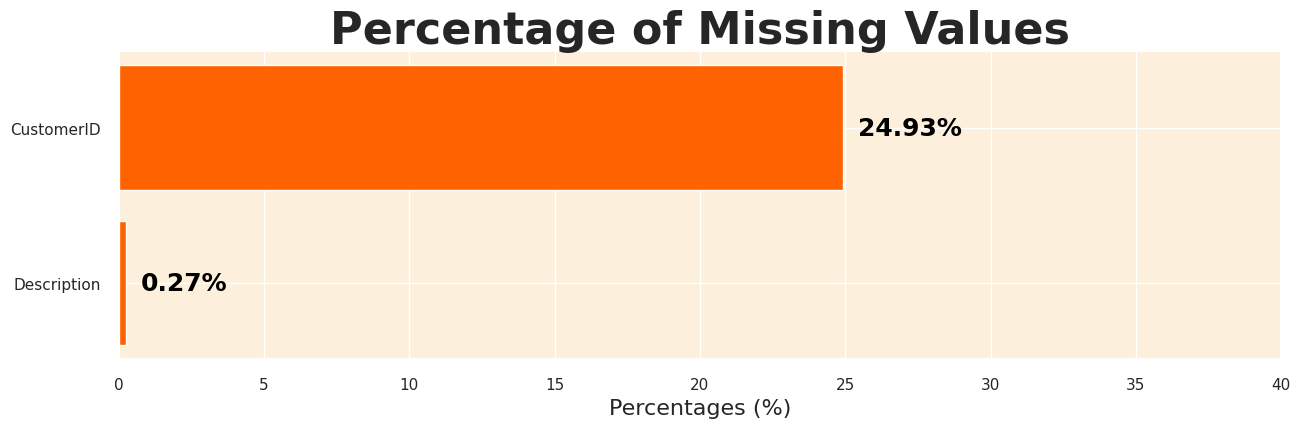

In [ ]:
missing_percentage.sort_values(ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(15,4))
ax.barh(missing_percentage.index, missing_percentage,color='#ff6200')

for i, (value, name) in enumerate(zip(missing_percentage.values, missing_percentage.index)):
  ax.text(value+0.5, i, f"{value:.2f}%",ha='left', va='center', fontweight='bold', fontsize=18, color='black')

ax.set_xlim([0, 40])

plt.title("Percentage of Missing Values", fontweight='bold', fontsize=32)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

Removing the Missing values

In [ ]:
df[df['CustomerID'].isnull() | df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [ ]:
df = df.dropna(subset=['CustomerID','Description'])

In [ ]:
df.isnull().sum().sum()

0

Checking for duplicated rows

In [ ]:
duplicated_rows = df[df.duplicated(keep=False)]
duplicated_rows_sorted = duplicated_rows.sort_values(by=['InvoiceNo','StockCode','Description','CustomerID','Quantity'])
duplicated_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom


Removing Duplicates

In [ ]:
print(f"The dataset contains {df.duplicated().sum()} duplicated rows that need to be removed")
df.drop_duplicates(inplace=True)

The dataset contains 5225 duplicated rows that need to be removed


Handling Cancelled Transactios

In [ ]:
df2 = df.sort_values(by = ['InvoiceNo'])
df2.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541717,C581569,20979,36 PENCILS TUBE RED RETROSPOT,-5,12/9/2011 11:58,1.25,17315.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


In [ ]:
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

cancelled_transactions = df[df['Transaction_Status'] =='Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


In [ ]:
cancelled_percentage = (cancelled_transactions.shape[0]/df.shape[0])*100
print(f'The percentage of cancelled transection in the dataset is {cancelled_percentage:.2f}%')

The percentage of cancelled transection in the dataset is 2.21%


Fixing the stock code

In [ ]:
unique_stock_codes = df['StockCode'].nunique()
print(f"The number of unique stock code is {unique_stock_codes}")


The number of unique stock code is 3684


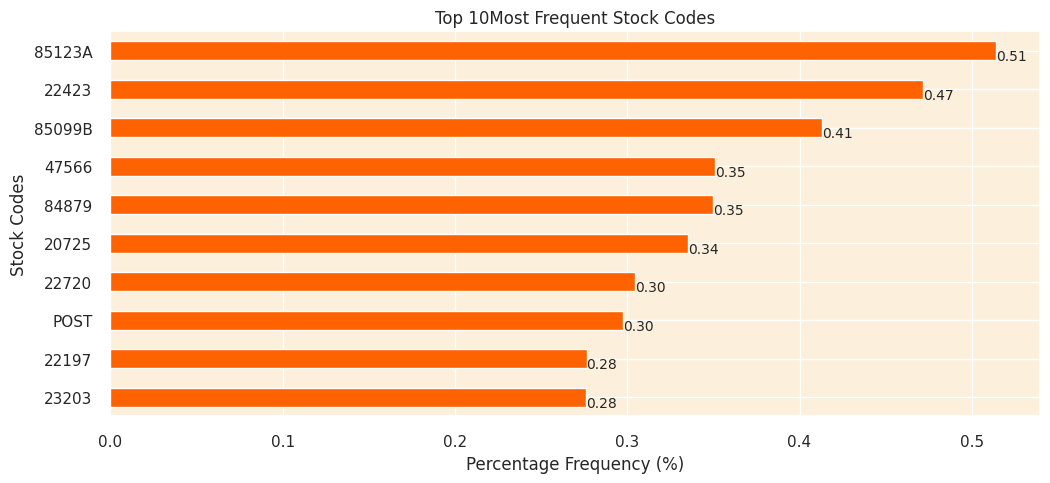

In [ ]:
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10)*100

plt.figure(figsize=(12,5))
top_10_stock_codes.plot(kind='barh', color = '#ff6200')

for index, value in enumerate(top_10_stock_codes):
  plt.text(value, index+0.25, f'{value:.2f}', fontsize=10)

plt.title('Top 10Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

print("Value counts of numeric character frequency in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequency in unique stock codes:
----------------------------------------------------------------------
5    3676
0       7
1       1
dtype: int64


In [ ]:
# step 1: Extract the unique stock codes from the DataFrame
unique_stock_codes =df['StockCode'].unique()

# step 2: Initialize an empty list to store the count of numeric characters for each unique stock code
numeric_char_counts = []

# step 3: Loop through each stock code in the list of unique stock codes
for stock_code in unique_stock_codes:
  # Convert the stock code to a string (in case it's not already)
  stock_code_str = str(stock_code)
  # Initialize a count for this stock code
  count = 0
  # Loop through each character in the string version of the stock code
  for char in stock_code_str:
    # check if the character is a digit
    if char.isdigit():
      # if it is , increment the count
      count += 1
  # Add the count to the list of counts
  numeric_char_counts.append(count)

# step 4: Convert the list of count into a pandas series
counts_series = pd.Series(numeric_char_counts)

# step 5: Use value_counts() to count how frequently each count occurs
frequency_of_counts = counts_series.value_counts()

# step 6: Print the results
print("Value counts of numeric character frequency in unique stock codes:")
print("-" * 70)
print(frequency_of_counts)



Value counts of numeric character frequency in unique stock codes:
----------------------------------------------------------------------
5    3676
0       7
1       1
dtype: int64


In [ ]:
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0,1)]

print("Anomalous stock codes")
print("-"*22)
for code in anomalous_stock_codes:
  print(code)

Anomalous stock codes
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [ ]:
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum()/ len(df)*100)

print(f"The Percentage of anomalous stock codes are {percentage_anomalous:.2f}%")

The Percentage of anomalous stock codes are 0.48%


In [ ]:
df.shape[0]

401604

In [ ]:
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

df.shape[0]

399689

Cleaning the Description Column

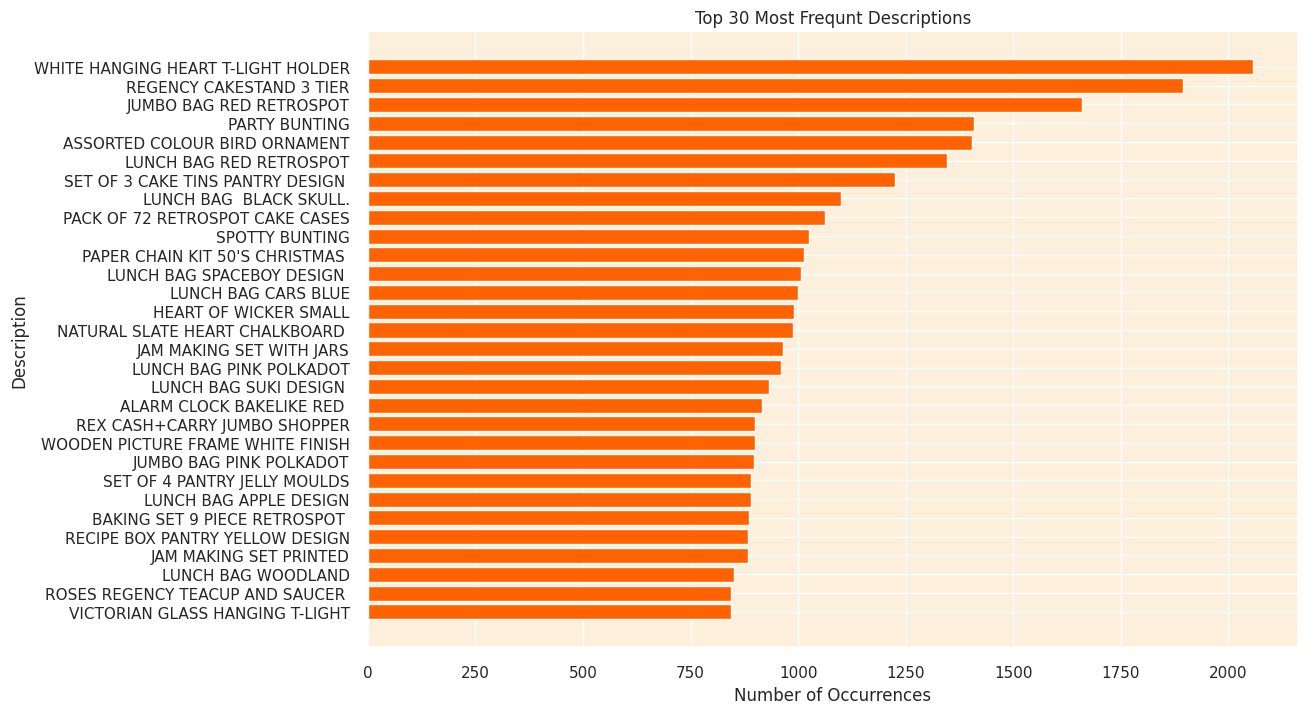

In [ ]:
description_counts = df['Description'].value_counts()

top_30_descriptions = description_counts[:30]

plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')

plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequnt Descriptions')

plt.show()

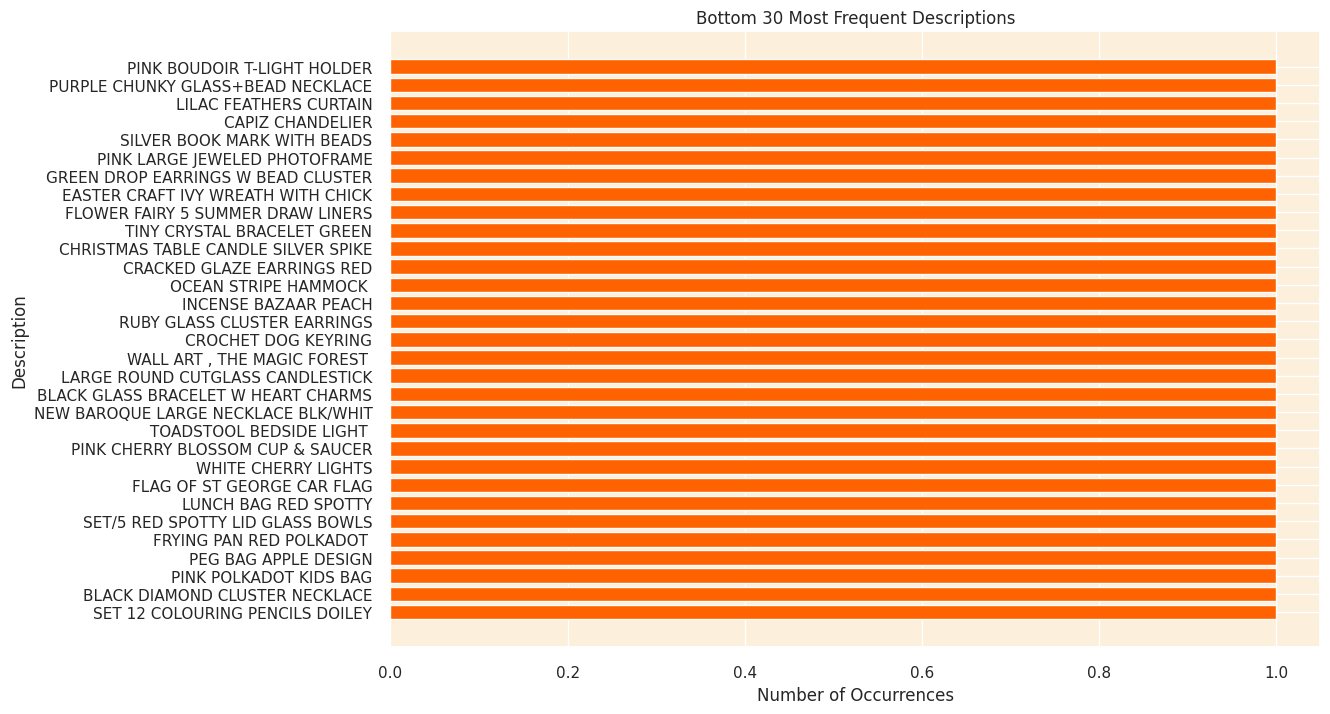

In [ ]:
description_counts = df['Description'].value_counts()

bottom_30_descriptions = description_counts[-31:]

plt.figure(figsize=(12,8))
plt.barh(bottom_30_descriptions.index[::-1], bottom_30_descriptions.values[::-1], color='#ff6200')

plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Bottom 30 Most Frequent Descriptions')

plt.show()

In [ ]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

service_related_percentage = df[df['Description'].isin(service_related_descriptions)].shape[0]/df.shape[0]*100

print(f"The percentage of recodes with useless description keywordsis: {service_related_percentage:.2f}%")

The percentage of recodes with useless description keywordsis: 0.02%


In [ ]:
df = df[~df['Description'].isin(service_related_descriptions)]

df['Description'] = df['Description'].str.upper()

In [ ]:
df.shape[0]

399606

Fixing Zero unit prices

In [ ]:
df['UnitPrice'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [ ]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


In [ ]:
df = df[df['UnitPrice']>0]

In [ ]:
df.shape[0]

399573

Fixing Outliers

In [ ]:
df.reset_index(drop=True, inplace=True)

df.shape[0]

399573

Feature Engineering (R)

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['InvoiceDay'] = df['InvoiceDate'].dt.date

customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

most_recent_date = df['InvoiceDay'].max()

customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

customer_data.drop(columns=['InvoiceDay'],inplace=True)

In [ ]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


Freture Engineering(F)

In [ ]:
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={"InvoiceNo": 'Total_Transactions'}, inplace=True)

total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': "Total_Purchased "},inplace=True)

customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

plt.show()

Feature Engineering (M)

In [ ]:
df['Total_Spend'] = df['UnitPrice']*df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend']/average_transaction_value['Total_Transactions']

customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID','Average_Transaction_Value']], on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


Unique Products purchased

In [ ]:
unique_product_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_product_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

customer_data = pd.merge(customer_data, unique_product_purchased, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


Behavioral features

In [ ]:
# Extracting the day of the week and the Hour
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Average Days between each purchase
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace = True)

# Favourite Shopping Day of the Week
favourite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favourite_shopping_day = favourite_shopping_day.loc[favourite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Favourite Shopping Hour
favourite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favourite_shopping_hour = favourite_shopping_hour.loc[favourite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]


In [ ]:
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favourite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favourite_shopping_hour, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


Geographical Features

In [ ]:
df['Country'].value_counts(normalize=True).head()

United Kingdom    0.890971
Germany           0.022722
France            0.020402
EIRE              0.018440
Spain             0.006162
Name: Country, dtype: float64

Creating a Domestic/Internation Purchase Coloumn

In [ ]:
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kindom' else 0)

customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,0
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0


In [ ]:
customer_data['Is_UK'].value_counts()

0    4282
Name: Is_UK, dtype: int64

Cancellation insights

In [ ]:
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

#Calculate the total cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']

#calculatethe cancellation frequency
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

In [ ]:
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency']/total_transactions['InvoiceNo']
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,0,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


Seasonality and Trends

In [ ]:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()

seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

def calculate_trend(spend_data):
  if len(spend_data > 1):
    x = np.arange(len(spend_data))
    slope, _, _, _,_ = linregress(x, spend_data)
    return slope

  else:
    return 0


In [ ]:
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns = {'Total_Spend': 'Spending_Trend'}, inplace=True)

spending_trends['Spending_Trend'].fillna(0, inplace = True)

customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')


In [ ]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,0,1.0,0.5,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000


Transfroming Data Type

In [ ]:
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

customer_data = customer_data.convert_dtypes()

In [ ]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,0,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0


In [ ]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4282 entries, 0 to 4281
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4282 non-null   string 
 1   Days_Since_Last_Purchase        4282 non-null   Int64  
 2   Total_Transactions              4282 non-null   Int64  
 3   Total_Purchased                 4282 non-null   Int64  
 4   Total_Spend                     4282 non-null   Float64
 5   Average_Transaction_Value       4282 non-null   Float64
 6   Unique_Products_Purchased       4282 non-null   Int64  
 7   Average_Days_Between_Purchases  4282 non-null   Float64
 8   Day_Of_Week                     4282 non-null   Int64  
 9   Hour                            4282 non-null   Int64  
 10  Is_UK                           4282 non-null   Int64  
 11  Cancellation_Frequency          4282 non-null   Int64  
 12  Cancellation_Rate               42

Removing Outliers

In [ ]:
model = IsolationForest(contamination=0.05, random_state=0)

customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,0,1,0.5,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1,0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1,0


Visualizing the distribution of outliers

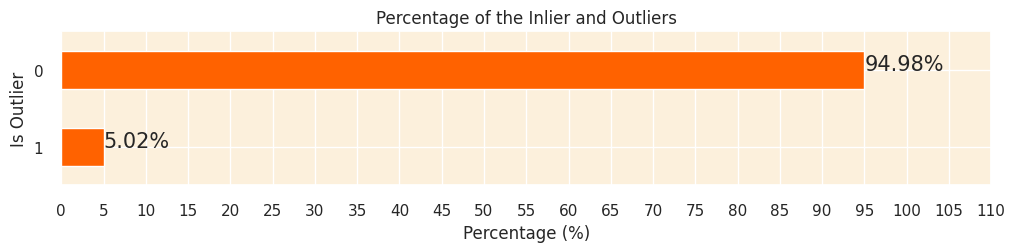

In [ ]:
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

plt.figure(figsize=(12,2))
outlier_percentage.plot(kind='barh', color='#ff6200')

for index, value in enumerate(outlier_percentage):
  plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of the Inlier and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

customer_data_cleaned.reset_index(drop=True, inplace=True)

In [ ]:
customer_data_cleaned.shape[0]

4067

Checking for co-linearity

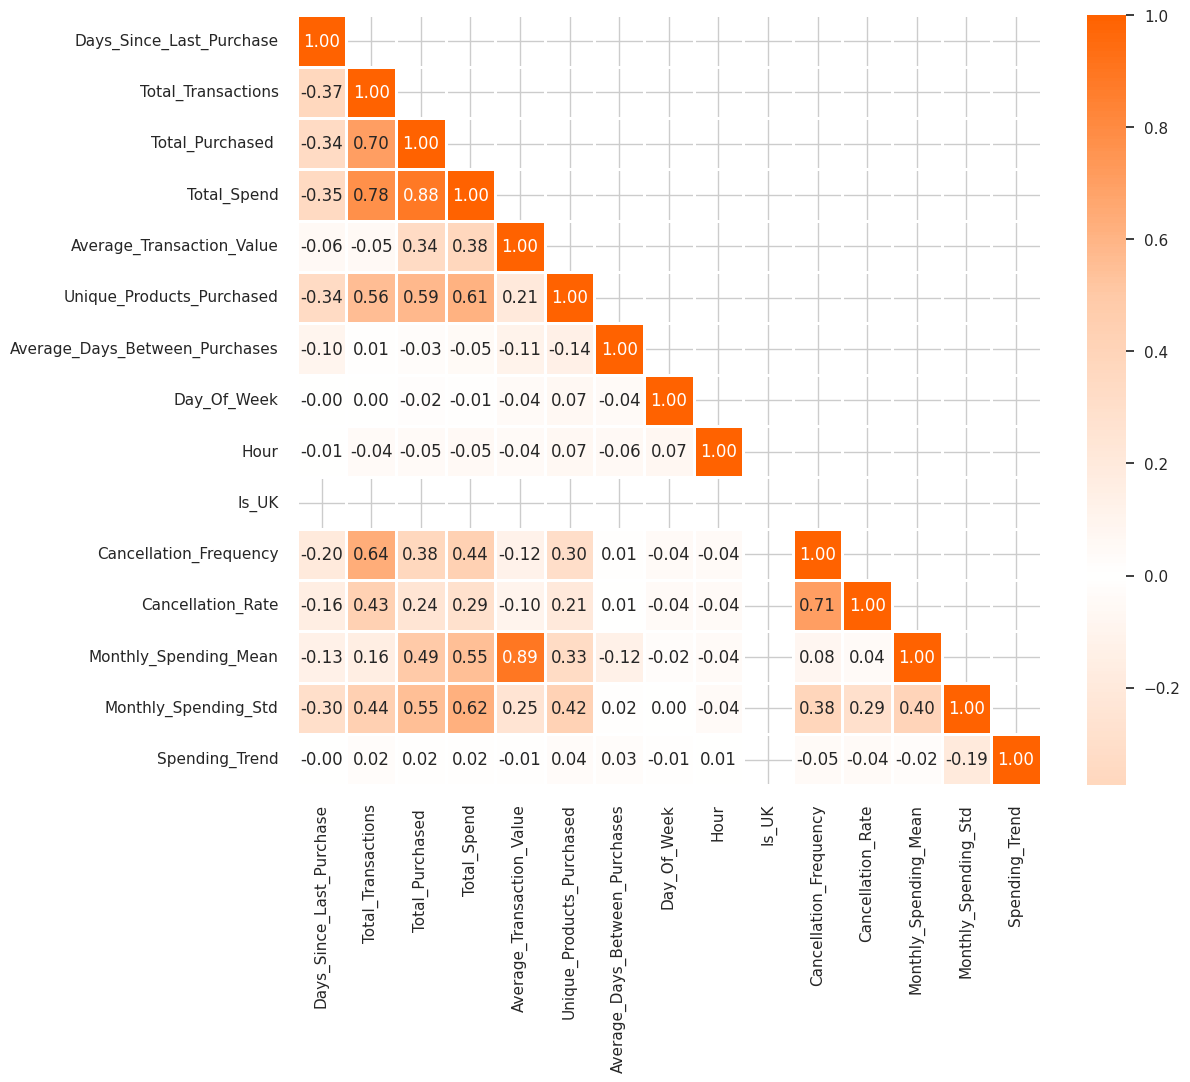

In [ ]:
sns.set_style('whitegrid')

corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('customer_map', colors, N=256)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidth=2)
plt.show()

Feature Scaling

In [ ]:
scaler = StandardScaler()

columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

customer_data_scaled = customer_data_cleaned.copy()

customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

customer_data_scaled.head()



,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,2.333984,-0.477563,-0.786610,-0.834204,-1.278118,-0.924240,-0.320136,1,-1.083809,0,0.431362,0.473109,-1.297885,-0.708889,0.092190
1,12347.0,-0.907117,0.743363,2.135678,2.457255,1.448860,0.836887,-0.127268,1,0.649518,0,-0.541655,-0.444289,0.944946,1.250186,0.117756
2,12348.0,-0.174608,0.010807,1.985878,0.263387,0.313254,-0.578921,0.720882,3,2.816176,0,-0.541655,-0.444289,0.010955,0.462152,-0.482758
3,12349.0,-0.746568,-0.721748,-0.037610,0.278897,5.177322,0.301643,-0.320136,0,-1.517140,0,-0.541655,-0.444289,4.011457,-0.708889,0.092190
4,12350.0,2.183469,-0.721748,-0.553588,-0.609376,0.025770,-0.665251,-0.320136,2,1.516181,0,-0.541655,-0.444289,-0.225489,-0.708889,0.092190


Dimentionality Reduction

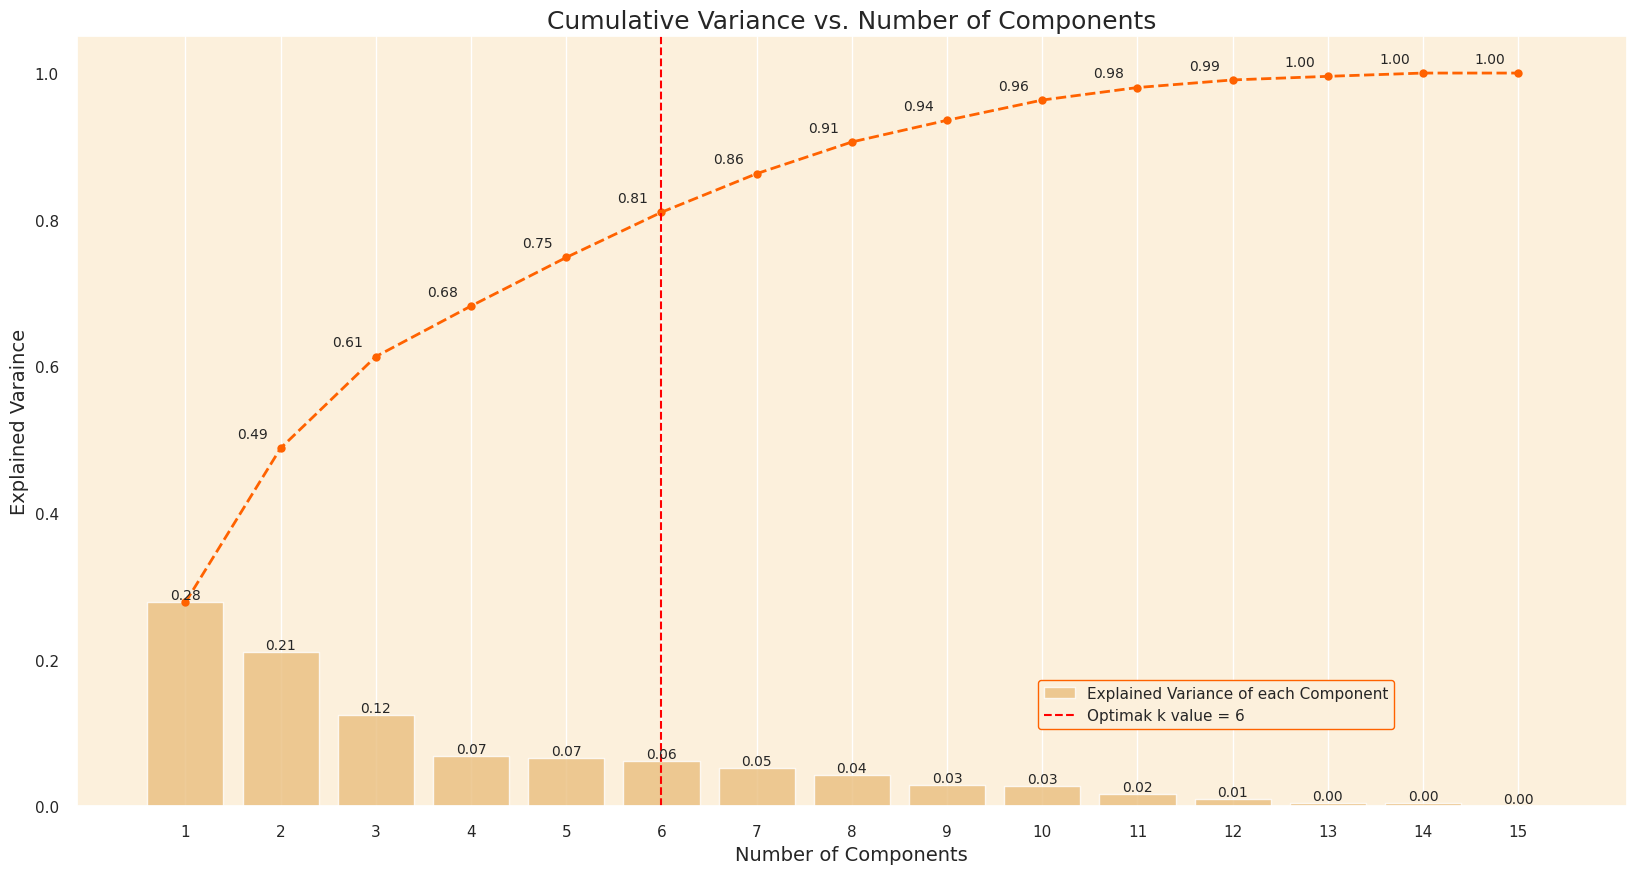

In [ ]:
customer_data_scaled.set_index('CustomerID', inplace=True)

pca = PCA().fit(customer_data_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

optimal_k = 6

sns.set(rc={'axes.facecolor': "#fcf0dc"}, style='darkgrid')

plt.figure(figsize=(20, 10))

barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y = explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

lineplot = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance, marker='o', linestyle='--', color='#ff6200', linewidth=2)

optimal_k_line = plt.axvline(optimal_k -1, color = 'red', linestyle='--', label=f'optimal k value = {optimal_k}')

plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Varaince', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of each Component', 'Cumulative Explained Variance', f'Optimak k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,
           edgecolor='#ff6200')

x_offset = -0.3
y_offset = 0.01

for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
  plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
  if i>0:
    plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

In [ ]:
scaler = StandardScaler()

columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

customer_data_scaled = customer_data_cleaned.copy()

customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,2.333984,-0.477563,-0.786610,-0.834204,-1.278118,-0.924240,-0.320136,1,-1.083809,0,0.431362,0.473109,-1.297885,-0.708889,0.092190
1,12347.0,-0.907117,0.743363,2.135678,2.457255,1.448860,0.836887,-0.127268,1,0.649518,0,-0.541655,-0.444289,0.944946,1.250186,0.117756
2,12348.0,-0.174608,0.010807,1.985878,0.263387,0.313254,-0.578921,0.720882,3,2.816176,0,-0.541655,-0.444289,0.010955,0.462152,-0.482758
3,12349.0,-0.746568,-0.721748,-0.037610,0.278897,5.177322,0.301643,-0.320136,0,-1.517140,0,-0.541655,-0.444289,4.011457,-0.708889,0.092190
4,12350.0,2.183469,-0.721748,-0.553588,-0.609376,0.025770,-0.665251,-0.320136,2,1.516181,0,-0.541655,-0.444289,-0.225489,-0.708889,0.092190


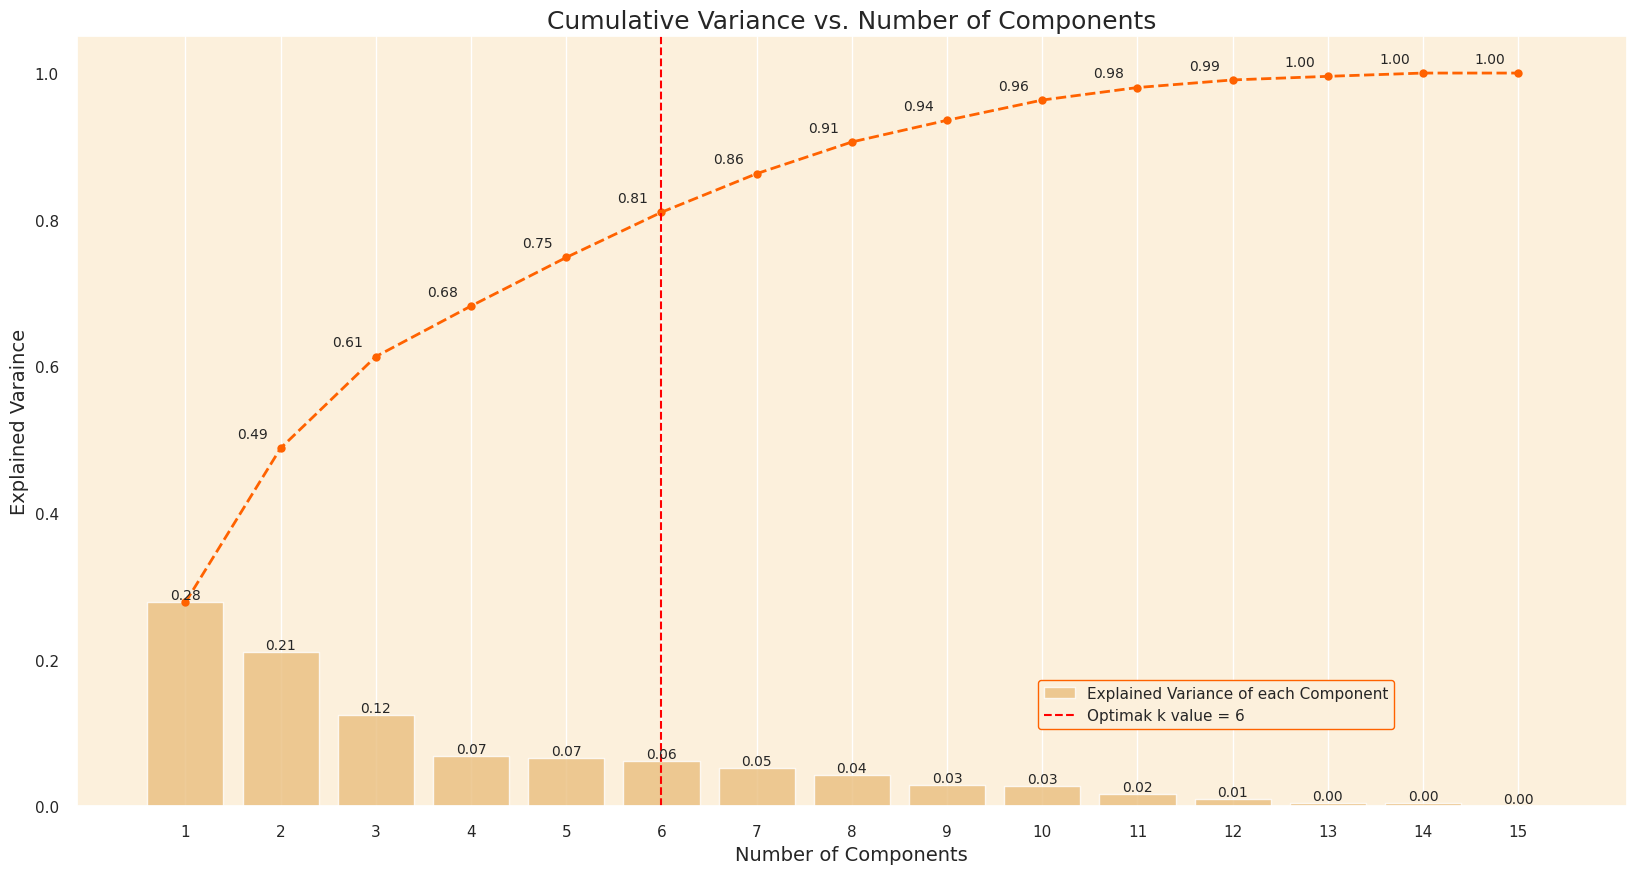

In [ ]:
customer_data_scaled.set_index('CustomerID', inplace=True)

pca = PCA().fit(customer_data_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

optimal_k = 6

sns.set(rc={'axes.facecolor': "#fcf0dc"}, style='darkgrid')

plt.figure(figsize=(20, 10))

barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y = explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

lineplot = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance, marker='o', linestyle='--', color='#ff6200', linewidth=2)

optimal_k_line = plt.axvline(optimal_k -1, color = 'red', linestyle='--', label=f'optimal k value = {optimal_k}')

plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Varaince', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of each Component', 'Cumulative Explained Variance', f'Optimak k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,
           edgecolor='#ff6200')

x_offset = -0.3
y_offset = 0.01

for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
  plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
  if i>0:
    plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

In [ ]:
pca = PCA(n_components=6)

customer_data_pca = pca.fit_transform(customer_data_scaled)

customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

customer_data_pca.index = customer_data_scaled.index

In [ ]:
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.185175,-1.707274,-1.507081,1.116801,-0.516602,-1.611330
12347.0,3.399734,-1.372866,1.807793,-1.042837,0.021684,0.895549
12348.0,0.640620,0.593249,0.608359,-0.823563,-0.477198,2.288357
12349.0,1.740694,-2.710507,5.581489,0.861872,0.888931,-1.433468
12350.0,-2.013366,-0.541151,0.611616,0.136166,-1.521776,0.075131


K-Means

Elbow Method

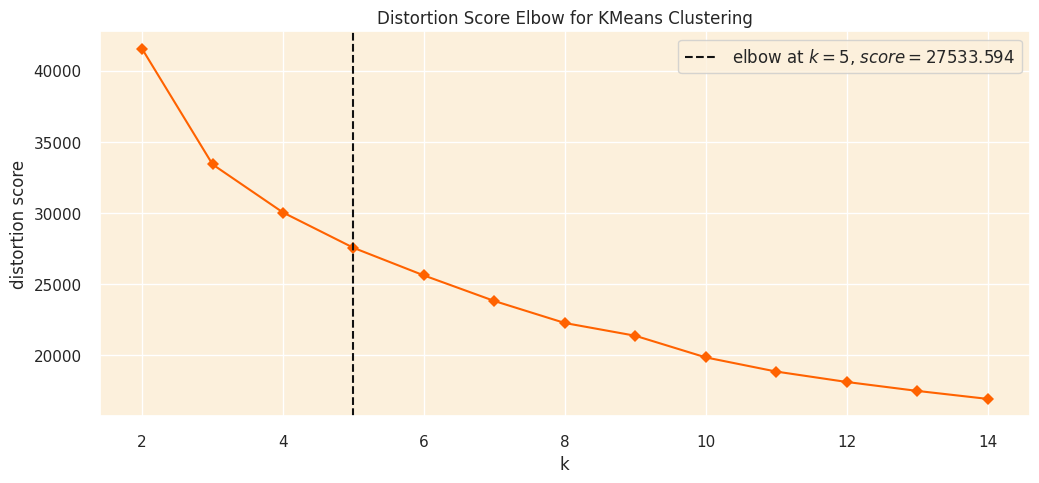

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

sns.set_palette(['#ff6200'])

km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

fig, ax = plt.subplots(figsize=(12,5))

visualizer = KElbowVisualizer(km, k=(2,15), timings=False, ax=ax)

visualizer.fit(customer_data_pca)

visualizer.show()

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

cluster_frequencies = Counter(kmeans.labels_)

label_mapping = {v: k for k, v in {2:1, 1:0, 0: 2}.items()}

new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

customer_data_cleaned['cluster'] = new_labels

customer_data_pca['cluster'] = new_labels

In [ ]:
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,0,1,0.5,0.0,0.0,0.0,1
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,2
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1


In [ ]:
colors = ['#e8000b', '#1ac938', '#023eff']

In [ ]:
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

fig = go.Figure()

fig.add_trace(go.Scatter3d(x = cluster_0['PC1'], y= cluster_0['PC2'], z =cluster_0['PC3'],
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x = cluster_1['PC1'], y= cluster_1['PC2'], z =cluster_1['PC3'],
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x = cluster_2['PC1'], y= cluster_2['PC2'], z =cluster_2['PC3'],
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor="white", title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor="white", title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor="white", title='PC3'),
    ),
    width = 900,
    height = 800
)
fig.show()


In [ ]:
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

fig = go.Figure()

fig.add_trace(go.Scatter3d(x = cluster_0['PC1'], y = cluster_0['PC2'], z=cluster_0['PC3'],
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x = cluster_1['PC1'], y = cluster_1['PC2'], z=cluster_1['PC3'],
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x = cluster_2['PC1'], y = cluster_2['PC2'], z=cluster_2['PC3'],
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width = 900,
    height = 800
)

fig.show()

In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

cluster_frequencies = Counter(kmeans.labels_)

label_mapping = {label:new_label for new_label, (label, _) in
                 enumerate(cluster_frequencies.most_common())}

label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

customer_data_cleaned['cluster'] = new_labels

customer_data_pca['cluster'] = new_labels

In [ ]:
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,0,1,0.5,0.0,0.0,0.0,2
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,2
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,2


In [ ]:
colors = ['#e8000b', '#1ac938', '#023eff']

In [ ]:
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

fig = go.Figure()

fig.add_trace(go.Scatter3d(x = cluster_0['PC1'], y = cluster_0['PC2'], z=cluster_0['PC3'],
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x = cluster_1['PC1'], y = cluster_1['PC2'], z=cluster_1['PC3'],
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x = cluster_2['PC1'], y = cluster_2['PC2'], z=cluster_2['PC3'],
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width = 900,
    height = 800
)

fig.show()